In [100]:
using Distributions, Turing, StatsPlots, StatsBase, Random, RDatasets, CSV, DataFrames

LoadError: ArgumentError: Package StatsBase not found in current path:
- Run `import Pkg; Pkg.add("StatsBase")` to install the StatsBase package.


# Assignment 2: hierarchical models

Students|
-------|

Name        |       Id
------------|----------
Ploni Almoni|123489589
John Smith  |923352302

## Summary

In this assignment we explore hierarchical models for analysis of data consisting of multiple related groups. The assignment is based on the [class material](https://bgu-abda.bitbucket.io/#lectures): 

5. Hierarchical models
6. Hierarchical models, cont.

The assignment consists of two problems. Solve the problems in either Jupyter or Pluto notebook.
In addition to computations, solutions must include **graphical visualization** and **numerical characterization** of the posterior.

## Problem 1: warp breaks

Julia provides to [R datasets](https://www.rdocumentation.org/packages/datasets/versions/3.6.2) via package RDatasets. We will use the [warpbreaks](https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/warpbreaks) dataset for this problem. You can load the dataset into data frame `df` as follows:

In [2]:
df = RDatasets.dataset("datasets", "warpbreaks");

Infer the probability distribution of warp breaks for each of two wool types. Compare the results under separate and hierarchical models. Conduct two studies:

1. Ignore warp tension and compare wool types based on all experiments. 
2. Account for warp tension in both the hierarchical model and the separate model.

## Problem 2. City of Norfolk employee salaries

City of Norfolk provides access to [employee salary data](https://data.norfolk.gov/Government/Employee-Salaries/4fsk-z8s8). Analyze the salary distributions 

1. by department;
2. by department and employee status.

Compare the analysis under separate and hierarchical models. A small number of groups are very different from the rest, how do you propose to handle the difference in the hierarchical model?

In [3]:
fpath = raw"C:\Users\noam\Repositories\bgu-abda.bitbucket.io\homework\02norfolk_employee_data.csv";

In [19]:
df = CSV.read(fpath, DataFrame);
first(df, 5)

,Department,Position Title,Employee Status,Initial Hire Date
,String,String,String,String
1,CF - MacArthur Memorial,Museum Attendant,Casual Part-time,06/04/2007
2,CF - MacArthur Memorial,Museum Attendant,Casual Part-time,11/13/2006
3,CF - MacArthur Memorial,Museum Attendant,Permanent Full-time,09/23/2020
4,CF - MacArthur Memorial,Museum Attendant,Permanent Full-time,01/07/2019
5,CF - MacArthur Memorial,Administrative Technician,Permanent Full-time,09/23/2015


### Exploratory Data Analysis

First, we will explore the dataset.

In [5]:
size(df) # (num_rows, num_columns)

(4399, 7)

In [6]:
names(df) # names of columns

7-element Vector{String}:
 "Department  "
 "Position Title"
 "Employee Status"
 "Initial Hire Date"
 "Date in Position"
 "Fair Labor Standards Act (FLSA) "
 "Base Salary"

Thus, the original dataset includes 4399 employees and 7 fields of information.

Let's trim the whitespaces surrounding "Department  " and filter unnecessary columns.

In [21]:
try # Running this block a second time throws an ArgumentError
    rename!(df, "Department  " => "Department");
catch
    ArgumentError
end

df = df[:, ["Department", "Employee Status", "Base Salary"]]
names(df)

3-element Vector{String}:
 "Department"
 "Employee Status"
 "Base Salary"

### Exploring Department

In [42]:
departments_count = sort(combine(groupby(df, [:Department,]), nrow => :count), "count", rev=true)
departments_count

,Department,count
,String,Int64
1,Fire-Rescue,502
2,Judicial - Sheriff and Jail,411
3,Police Field Operations-Sworn,375
4,Hum Svc Div of Social Services,365
5,Police Investigative Svc-Sworn,145
6,PW Waste Management,94
7,PW Storm Water Mgmt,93
8,Utilities Water Production,82
9,Utilities WasteWater,81


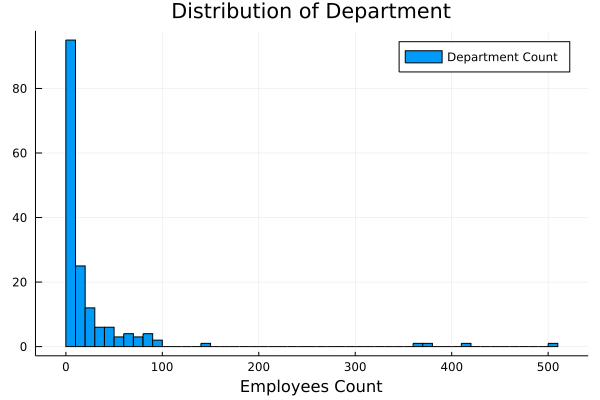

In [76]:
histogram(departments_count.count, title="Distribution of Department", xlabel="Employees Count", label="Department Count")

<b>Observation</b>: There are 165 departments total. The top 5 largest departments consist of ~40% of the employees. The remaining 160 departments hold the other ~60%.

### Exploring Employee Status

In [40]:
employee_status_count = sort(combine(groupby(df, [:"Employee Status",]), nrow => :count), "count", rev=true)
employee_status_count 

,Employee Status,count
,String,Int64
1,Permanent Full-time,3538
2,State Comp Board Retirement,526
3,Intermittent Temporary,106
4,Special Project w/ Retirement,69
5,Periodic Part-time,32
6,Special Project,26
7,Casual Part-time,20
8,Constitutional OfficePart-time,18
9,Permanent Part-time,15


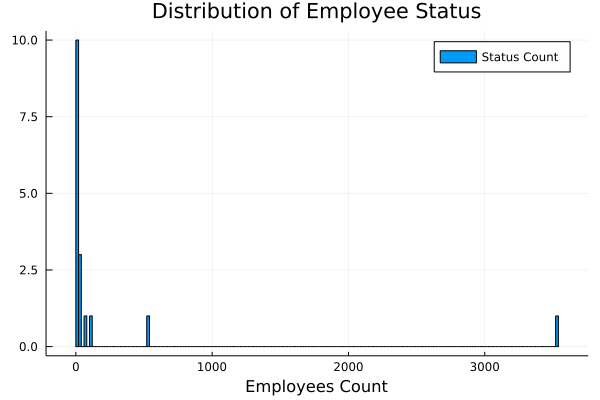

In [77]:
histogram(employee_status_count.count, title="Distribution of Employee Status", xlabel="Employees Count", label="Status Count")

<b>Observation</b>: The are 17 employement statuses total. 14 statuses have little employee counts (166) and 3 statuses have the lion's share (remaining 4170)

### Exploring Base Salary

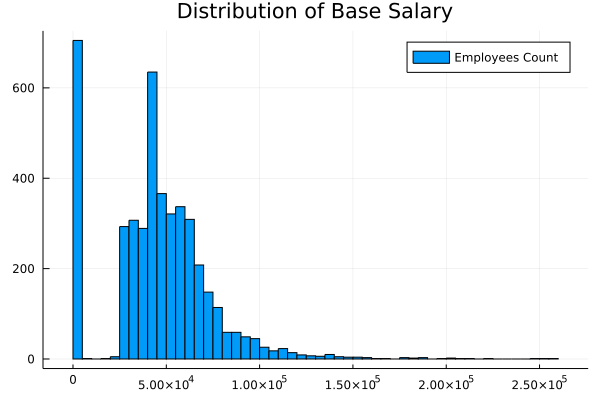

In [71]:
histogram(df."Base Salary", title="Distribution of Base Salary", label="Employees Count")

Minimum Salary: 9.5

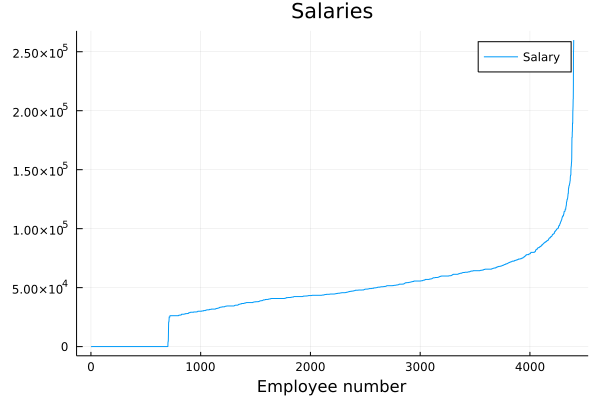

In [78]:
print("Minimum Salary: ", minimum(df."Base Salary"))
plot(sort(df."Base Salary"), title="Salaries", xlabel="Employee number", label="Salary")

<b>Observation</b>: The salary distribution is clustered: employees either have salaries in the range (9,150) or in (3500, 260000). The two modes are 

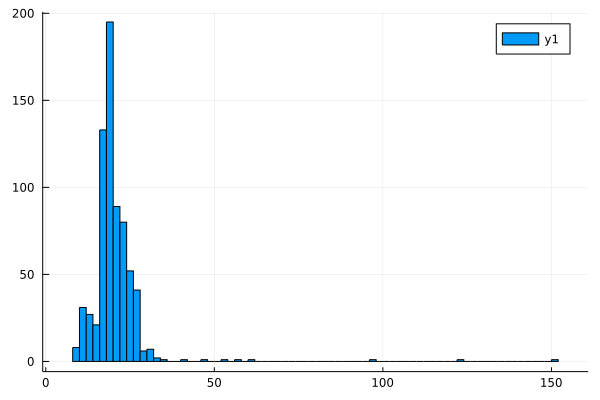

In [98]:
h = histogram(sort(df."Base Salary")[begin:701])

In [99]:
mode(h)

LoadError: MethodError: no method matching iterate(::Plots.Plot{Plots.GRBackend})
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:664
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Int64[39m) at range.jl:664
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{var"#s79", var"#s78"} where {var"#s79", var"#s78"<:Dict}, Base.ValueIterator{var"#s77"} where var"#s77"<:Dict} at dict.jl:693
[0m  ...

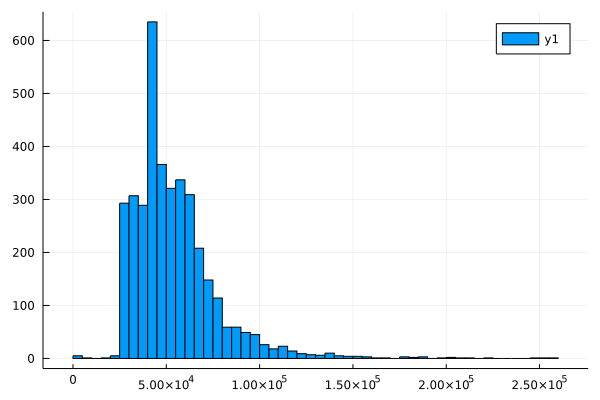

In [96]:
h = histogram(sort(df."Base Salary")[701:end])

In [48]:
df

,Department,Employee Status,Base Salary
,String,String,Float64
1,CF - MacArthur Memorial,Casual Part-time,12.51
2,CF - MacArthur Memorial,Casual Part-time,12.51
3,CF - MacArthur Memorial,Permanent Full-time,26200.0
4,CF - MacArthur Memorial,Permanent Full-time,26200.0
5,CF - MacArthur Memorial,Permanent Full-time,33454.1
6,CF - MacArthur Memorial,Permanent Full-time,55193.6
7,CF - MacArthur Memorial,Permanent Full-time,59534.6
8,CF - MacArthur Memorial,Permanent Full-time,61718.1
9,CF-Cultural&Convention Center,Intermittent Temporary,11.91


In [16]:
names(df)

3-element Vector{String}:
 "Department"
 "Employee Status"
 "Base Salary"